# Аналитика в стартапе, продающий продукты питания.

**Цель**: Разобраться, как ведут себя пользователи в приложении.

**Задачи**:
* Подготовить данные
* Изучить и проверить данные
* Изучить воронку продаж
* Исследовать результаты A/A/B-эксперимента

**Данные для исследования**:

Каждая запись в логе — это действие пользователя, или событие.
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.




## Изучение данных

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import math as mth

import plotly.io as pio
pio.renderers.default = 'svg'

from plotly import graph_objects as go
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('secret.csv',
                     sep='\t')
except Exception as err:
    print('Error:', err)    

In [3]:
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Данные успешно прочитаны, перейдем к предобработке

## Предобработка данных

Напишем функцию, которая вернет нам основную информацию по датафрейму (количество пропусков, тип данных, дубликаты)

In [4]:
def primary_info(df):
    display(df.head())
    print()
    print('Проверка на пропущенные значения:')
    display(pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm'))
    print('----------------')
    print()
    print('Проверка типа данных на корректность:')
    print(df.info())
    print('----------------')
    print()
    print('Количество дубликатов:', df.duplicated().sum())

In [5]:
primary_info(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



Проверка на пропущенные значения:


,0
EventName,0.000000
DeviceIDHash,0.000000
EventTimestamp,0.000000
ExpId,0.000000


----------------

Проверка типа данных на корректность:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
----------------

Количество дубликатов: 413


* Пропусков нет, это отлично
* Я бы исправил названия столбцов, приведя их к нижнему регистру и добавив андерскор
* И можно еще рассмотреть столбцы EventName и ExpId на возможность смены типа данных на category
* Есть 413 дубликатов, сейчас на них поглядим

Начнем по порядку

In [6]:
new_columns = {
    'EventName':'event_name',
    'DeviceIDHash':'device_id',
    'EventTimestamp':'event_timestamp',
    'ExpId':'exp_id'
}

df.rename(columns=new_columns, inplace=True)
df.head()

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Готово, теперь разберемся с типами данных

In [7]:
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

5 значений, значит здесь идеально подойдет category. Можно и не менять, но так сэкономим память.

In [8]:
df1 = df.copy()

In [9]:
df['event_name'] = df['event_name'].astype('category')
df.dtypes

event_name         category
device_id             int64
event_timestamp       int64
exp_id                int64
dtype: object

Что касается exp_id - можно просто поменять тип на category, а можно еще и заменить 246,247 на A1 и A2 (контрольные группы), а 248 на B (экспериментальная группа). Вот так и сделаем

In [10]:
mapping = {
    246:'A1',
    247:'A2',
    248:'B'
}

df['exp_id'] = df['exp_id'].map(mapping)

In [11]:
df['exp_id'].unique()

array(['A1', 'B', 'A2'], dtype=object)

In [12]:
df['exp_id'] = df['exp_id'].astype('category')
df.dtypes

event_name         category
device_id             int64
event_timestamp       int64
exp_id             category
dtype: object

Теперь сравним сколько памяти используют оба датафрейма (df1 без category)

In [13]:
print('Без category: {} mb'.format(round(df1.memory_usage().sum()*0.00000095367432, 2)))
print('Category: {} mb'.format(round(df.memory_usage().sum()*0.00000095367432, 2)))

Без category: 7.45 mb
Category: 4.19 mb


Почти в 2 раза меньше теперь кушает памяти

In [14]:
del(df1)

Перейдем к дубликатам

In [15]:
df[df.duplicated(keep=False)]

,event_name,device_id,event_timestamp,exp_id
452,MainScreenAppear,5613408041324010552,1564474784,B
453,MainScreenAppear,5613408041324010552,1564474784,B
2348,CartScreenAppear,1694940645335807244,1564609899,B
2350,CartScreenAppear,1694940645335807244,1564609899,B
3572,MainScreenAppear,434103746454591587,1564628377,B
...,...,...,...,...
242359,PaymentScreenSuccessful,2382591782303281935,1565206049,A1
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,A1
242362,CartScreenAppear,2382591782303281935,1565206049,A1
242634,MainScreenAppear,4097782667445790512,1565206618,A1


И правда 413 записей - дубликаты, удалим их

In [16]:
df.drop_duplicates(inplace=True)

И добавим 2 столбца - один с датой и временем, другой просто с датой.

Столбец event_timestamp - это unix-время. Для его конвертации в datetime будем использовать pd.to_datetime() с параметром unit = 's'

In [17]:
df['event_datetime'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [18]:
df

,event_name,device_id,event_timestamp,exp_id,event_datetime
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,A2,2019-08-07 21:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,A1,2019-08-07 21:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,A1,2019-08-07 21:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,A1,2019-08-07 21:14:58


In [19]:
df['event_date'] = df['event_datetime'].dt.date
df['event_date'] = pd.to_datetime(df['event_date'])

In [20]:
df

,event_name,device_id,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,A2,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,A1,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,A1,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,A1,2019-08-07 21:14:58,2019-08-07


In [21]:
df.dtypes

event_name               category
device_id                   int64
event_timestamp             int64
exp_id                   category
event_datetime     datetime64[ns]
event_date         datetime64[ns]
dtype: object

Данные готовы, приступим к изучению и проверке данных

## Изучение и проверка данных

### Количество событий в логе

Если говорить про общее число событий, то это количество записей в нашем датафрейме, так как каждая запись - это какое-то событие

In [22]:
event_count = df.shape[0]

print('Всего событий в логе -', event_count)

Всего событий в логе - 243713


### Количество пользователей в логе

In [23]:
user_count = df['device_id'].nunique()

print('Всего пользователей в логе -', user_count)

Всего пользователей в логе - 7551


### Среднее количество событий на одного пользователя

In [24]:
print('В среднем на пользователя приходится {} события'.format(int(event_count/user_count)))

В среднем на пользователя приходится 32 события


### Проверим, за какой период времени наши данные. Определим, с какого момента данные полные и отбросим более старые

In [25]:
pd.DataFrame(df['event_datetime'].describe())

,event_datetime
count,243713
unique,176654
top,2019-08-01 14:40:35
freq,9
first,2019-07-25 04:43:36
last,2019-08-07 21:15:17


In [26]:
df['event_datetime'].max()-df['event_datetime'].min()

Timedelta('13 days 16:31:41')

Максимальная дата - 7 августа 2019, минимальная - 25 июля 2019. Данные за 13 дней

Посмотрим на распределение событий в логе по дате и времени

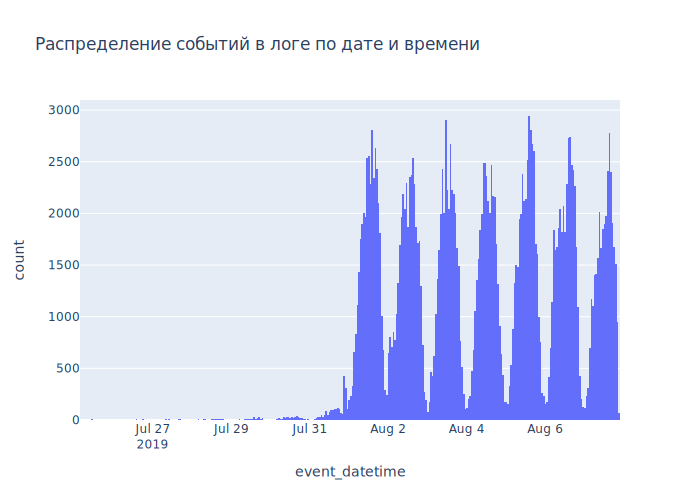

In [27]:
fig = px.histogram(df, x='event_datetime',
                   title='Распределение событий в логе по дате и времени')
fig.show()

Отчетливо видно, что данные у нас неполные. Верным будет отбросить все данные до 1 августа. Выходит, на самом деле данные у нас не за 13 дней, а за 7

In [28]:
df = df.query('event_date >= "2019-08-01"')

Посмотрим еще раз на гистограмму

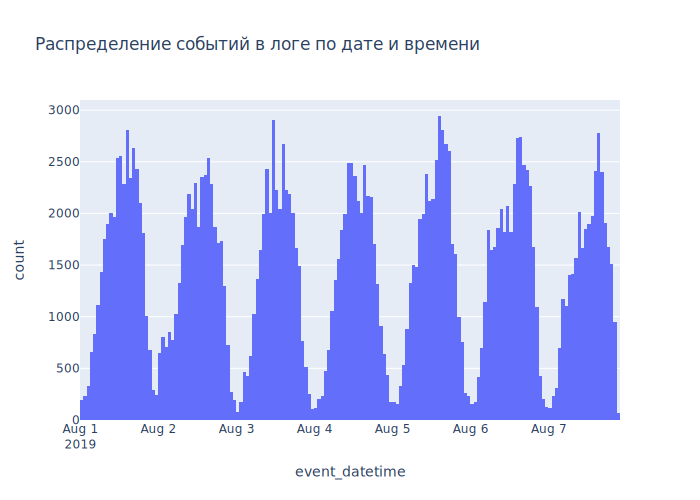

In [29]:
fig = px.histogram(df, x='event_datetime',
                   title='Распределение событий в логе по дате и времени')
fig.show()

### Количество событий и пользователей, которое мы потеряли, отбросив старые данные

In [30]:
print('Всего событий в логе -', df.shape[0])
print('Потеряли {:.2%} событий'.format(1-(df.shape[0]/event_count)))

Всего событий в логе - 240887
Потеряли 1.16% событий


In [31]:
print('Всего пользователей в логе -', df['device_id'].nunique())
print('Потеряли {:.2%} пользователей'.format(1-(df['device_id'].nunique()/user_count)))

Всего пользователей в логе - 7534
Потеряли 0.23% пользователей


Итак, потеряли мы данных:

![image.jpg](https://www.meme-arsenal.com/memes/e37c687a7e894eb7b8822b16db8a2d4b.jpg)

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп

In [32]:
pd.DataFrame(df.groupby('exp_id').agg({'device_id':'nunique'}))

,device_id
exp_id,
A1,2484
A2,2513
B,2537


К тому же распределены почти одинаково, отлично

## Изучение воронки событий

### Посмотрим, какие события есть в логах, как часто они встречаются

In [33]:
df['event_name'].unique()

['Tutorial', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
Categories (5, object): ['Tutorial', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

То есть всего у нас 5 разных событий: 
- MainScreenAppear - главный экран
- PaymentScreenSuccessful - экран успешной оплаты
- CartScreenAppear - экран оплаты
- OffersScreenAppear - экран предложений
- Tutorial - руководство по использованию (обучение)

Посмотрим, как часто они встречаются

In [34]:
pd.DataFrame(df['event_name'].value_counts())

,event_name
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


### Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие

In [35]:
users_by_event = (
    df
        .groupby('event_name')
        .agg({'device_id':'nunique'})
        .sort_values(by='device_id', ascending=False)
        .rename(columns={'device_id':'count_users'})
)

users_by_event

,count_users
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Доля пользователей, которые хоть раз совершали событие

In [36]:
users_by_event['ratio_of_total'] = round(users_by_event['count_users'] / df['device_id'].nunique(), 3)
users_by_event

,count_users,ratio_of_total
event_name,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470
Tutorial,840,0.111


Конверсия на 1 шаге меньше 1, значит необязтельно проходить по всем шагам воронки. Вероятно, у таких пользователей уже есть ссылка на определенный товар в магазине, и при переходе по этой ссылке, они попадают сразу на страницу с товаром - OffersScreenAppear

### Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?

Какая воронка по сути должна быть:
1. Руководство по использованию / Обучение. Максимальное число событий, и далее на каждом пункте мы либо теряем пользователей, либо их количество сохраняется.
2. Главный экран.
3. Экран предложения / товара.
4. Экран оплаты
5. Экран с успешной оплатой

Какая получается у нас:
1. Руководство по использованию / Обучение (1005)
2. Главный экран (117 328)
3. Экран предложения/товара (46 333)
4. Экран оплаты (42 303)
5. Экран с успешной оплатой (33 918)

Обучение никто не проходит... Видимо, мы не предлагаем пройти обучение при первом запуске или кнопка с руководством по использованию может быть интуитивно непонятна пользователю, и он ее просто не может найти. Так что при построении воронки не будем учитывать события, связанные с обучением (tutorial)

Посмотрим на распределение пользователей по группам эксперимента

In [37]:
df.pivot_table(
    index='event_name',
    columns='exp_id',
    values='device_id',
    aggfunc='nunique'
).sort_values(by='A1', ascending=False)

exp_id,A1,A2,B
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Распределение по группам практически идентично

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки

Спева рассмотрим строгую воронку, то есть в расчет берем только последовательные шаги пользователя

In [38]:
users = df.query('event_name != "Tutorial"').pivot_table(
    index='device_id',
    columns='event_name',
    values='event_datetime',
    aggfunc='min'
)

users

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
device_id,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45
...,...,...,...,...
9217594193087726423,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57
9219463515465815368,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16
9220879493065341500,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT


In [39]:
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_main_screen_appear = users[step_1].shape[0]
n_offers_screen_appear = users[step_2].shape[0]
n_cart_screen_appear = users[step_3].shape[0]
n_payment_screen_successful = users[step_4].shape[0]

In [40]:
dr = pd.DataFrame({'event_name':['Главный экран', 'Экран с товаром', 'Начали оформлять заказ', 'Оплатили'],
                   'users':[n_main_screen_appear, n_offers_screen_appear, n_cart_screen_appear, n_payment_screen_successful]})
dr = dr.set_index('event_name')
dr

,users
event_name,
Главный экран,7419
Экран с товаром,4201
Начали оформлять заказ,1767
Оплатили,454


In [41]:
dr['ratio_of_previous'] = round(dr['users'] / dr.shift(1)['users'], 2)
dr.fillna(1, inplace=True)

dr

,users,ratio_of_previous
event_name,,
Главный экран,7419,1.00
Экран с товаром,4201,0.57
Начали оформлять заказ,1767,0.42
Оплатили,454,0.26


- На экран с товаром проходят 57% пользователей от количества пользователей с главного экрана
- Оформлять заказ начали 42% пользователей от количества пользователей, попавших на экран с товаром
- Оплатили заказ только 26% пользователей от количества пользователей, начавших его оформлять

Для наглядности построим график воронки с помощью plotly

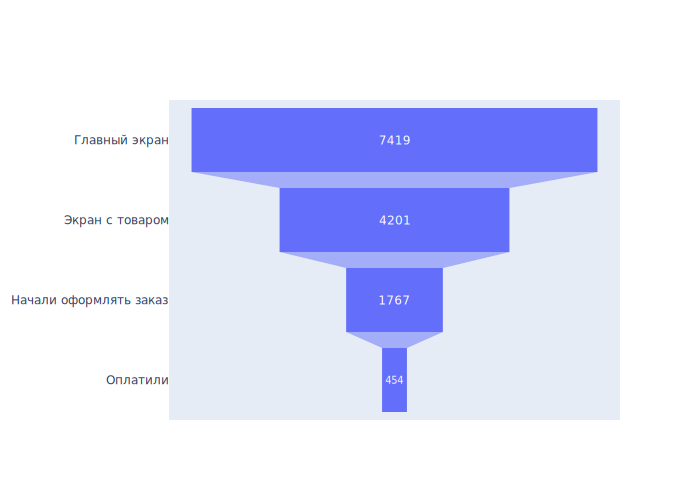

In [42]:
funnel = go.Figure(
    go.Funnel(
        y=[
            'Главный экран',
            'Экран с товаром',
            'Начали оформлять заказ',
            'Оплатили'],
        x=[
            n_main_screen_appear,
            n_offers_screen_appear,
            n_cart_screen_appear,
            n_payment_screen_successful]
    )
)
funnel.show()

При наведение на каждый шаг воронки мы видим:
1. Количество пользователей на данном шаге и название события
2. Процент числа пользователей на данном шаге от числа пользователей на первом шаге (% of initial)
3. Процент числа пользователей на данном шаге от числа пользователей на предыдущем шаге (% of previous)
4. Доля пользователей на каждом шаге от общего количества пользователей

Анализ нестрогой воронки

In [43]:
users_by_event = users_by_event.query('index != "Tutorial"')
users_by_event

,count_users,ratio_of_total
event_name,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470


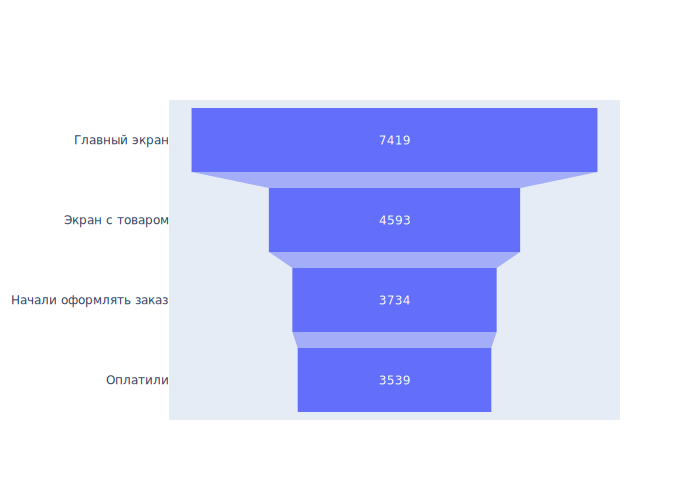

In [44]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Главный экран',
            'Экран с товаром',
            'Начали оформлять заказ',
            'Оплатили'],
        x=[
            users_by_event.iloc[0]['count_users'],
            users_by_event.iloc[1]['count_users'],
            users_by_event.iloc[2]['count_users'],
            users_by_event.iloc[3]['count_users']]
    )
)
fig.show()

От общего количества пользователей проходят:
- На главный экран - 98.5% пользователей
- На экран с товаром - 61% пользователей
- Оформлять заказ начали 50% пользователей
- Оплатили заказ - 47% пользователей

### На каком шаге теряем больше всего пользователей?

Строгая воронка

Отобразим график воронки еще раз

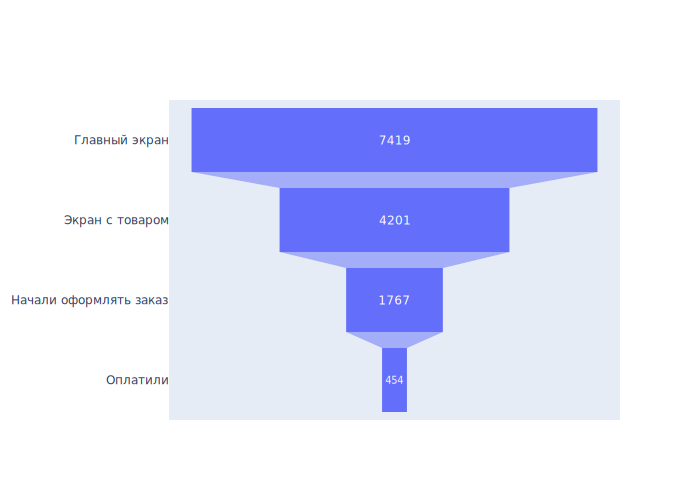

In [45]:
funnel.show()

По шагам:
1. 7419 пользователей - 100%.
2. 4201 пользователей (-3218) - потеряли 44% пользователей с 1 шага
3. 1767 пользователей (-2434) - потеряли 58% пользователей с 2 шага
4. 454 пользователей (-1313) - потеряли 75% пользователей с 3 шага

В абсолютных показателях мы теряем больше всего пользователей на 2 шаге. Однако, думаю, здесь правильнее будет рассматривать относительный показатель, и по нему мы теряем больше всего пользователей на последнем шаге - 75%. Где-то у нас проблема с оплатой товара...

Нестрогая воронка

In [46]:
users_by_event

,count_users,ratio_of_total
event_name,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470


Потеряли пользователей от общего количества:
1. 7419 пользователей (-115) - 98.5% от общего числа пользователей.
2. 4593 пользователей (-2941) - потеряли 39% пользователей
3. 3734 пользователей (-3800) - потеряли 50% пользователей
4. 3539 пользователей (-3995) - потеряли 53% пользователей

Больше всего пользователей теряем на шаге с оплатой товара - 53% (3995) от общего числа пользователей

### Какая доля пользователей доходит от первого события до оплаты?

Строгая воронка

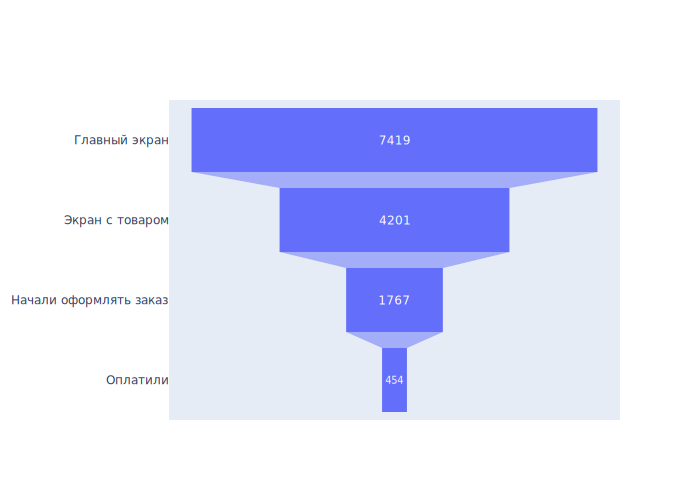

In [47]:
funnel.show()

По воронке видим, что до последнего шага доходят только 6% пользователей

Нестрогая воронка

In [48]:
users_by_event

,count_users,ratio_of_total
event_name,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470


In [49]:
print('От первого события до оплаты доходят {:.0%} пользователей'.format(users_by_event.iloc[-1]['ratio_of_total']))

От первого события до оплаты доходят 47% пользователей


По нестрогой воронке ситуация в разы лучше - 47% пользователей доходят до оплаты

##  Изучим результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [50]:
total_count_by_exp_id = pd.DataFrame(df.groupby('exp_id').agg({'device_id':'nunique'}))
total_count_by_exp_id

,device_id
exp_id,
A1,2484
A2,2513
B,2537


Так же проверим датафрейм на наличие фликеров - пользователей, попавших в несколько групп эксперимента.

In [51]:
clear_data = (
    df
        .groupby('device_id', as_index=False)
        .agg({'exp_id':'nunique'})
)

clear_data

,device_id,exp_id
0,6888746892508752,1
1,6909561520679493,1
2,6922444491712477,1
3,7435777799948366,1
4,7702139951469979,1
...,...,...
7529,9217594193087726423,1
7530,9219463515465815368,1
7531,9220879493065341500,1
7532,9221926045299980007,1


Каждая строка - это уникальный пользователь с количеством групп, в которых он был - если больше 1, то значит пользователь использовал приложение и в контрольной группе, и в экспериментальной

Теперь подсчитаем количество пользователей, у которых значение в столбце exp_id больше 1

In [52]:
to_die = clear_data.query('exp_id > 1')
to_die.shape[0]

0

Все пользователи на своем месте, отлично

### Проверим, находят ли статистические критерии разницу между выборками A1 и A2

In [53]:
users_by_event_name = df.query('event_name != "Tutorial"').pivot_table(
    index='event_name',
    columns='exp_id',
    values='device_id',
    aggfunc='nunique'
).sort_values(by='A1', ascending=False)

users_by_event_name

exp_id,A1,A2,B
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,0,0,0


Формулируем гипотезы:
* H0 - нет статистически значимой разницы между долями двух генеральных совокупностей по выборокам A1 и A2
* H1 - присутствует статистически значимая разница между долями двух генеральных совокупностей по выборокам A1 и A2

In [54]:
def check_group(group1, group2, event):
    alpha = 0.003125 # критический уровень статистической значимости
    
    # пропорция успехов в первой группе:
    p1 = users_by_event_name[group1][event] / total_count_by_exp_id.loc[group1]['device_id']

    # пропорция успехов во второй группе:
    p2 = users_by_event_name[group2][event] / total_count_by_exp_id.loc[group2]['device_id']

    # пропорция успехов в комбинированном датасете:
    p_combined = ((users_by_event_name[group1][event] + users_by_event_name[group2][event]) / 
        (total_count_by_exp_id.loc[group1]['device_id'] + total_count_by_exp_id.loc[group2]['device_id']))

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = (difference / mth.sqrt(p_combined * (1 - p_combined) * 
              (1/total_count_by_exp_id.loc[group1]['device_id'] + 1/total_count_by_exp_id.loc[group2]['device_id'])))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = (difference / mth.sqrt(
        p_combined * (1 - p_combined) * 
        (1 / total_count_by_exp_id.loc[group1]['device_id'] + 1 / total_count_by_exp_id.loc[group2]['device_id'])
    ))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(event,'p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [55]:
for event in users_by_event_name.index:
    check_group('A1', 'A2', event)
    print('')

MainScreenAppear p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение:  nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод** - нет оснований полагать, что доли по каждому шагу в выборках A1 и A2 различны, значит выборки корректны. 

### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие

In [56]:
users_by_event_name

exp_id,A1,A2,B
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,0,0,0


Самое популярное событие - это, конечно, главный экран - MainScreenAppear.

Посчитаем долю пользователей, совершивших это событие в каждой из контрольных групп

In [57]:
top_event = pd.concat([pd.DataFrame(users_by_event_name.loc['MainScreenAppear']),
                 pd.DataFrame(df.groupby('exp_id')['device_id'].nunique())], axis=1)

top_event.rename(columns={'device_id':'total_users'}, inplace=True)
top_event = top_event.query('index != "B"')
top_event

,MainScreenAppear,total_users
exp_id,,
A1,2450,2484
A2,2476,2513


In [58]:
top_event['ratio'] = round(top_event['MainScreenAppear'] / top_event['total_users'], 3)
top_event

,MainScreenAppear,total_users,ratio
exp_id,,,
A1,2450,2484,0.986
A2,2476,2513,0.985


### Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой

Формулируем гипотезы:
* H0 - нет статистически значимой разницы между долями двух генеральных совокупностей по выборокам A1/A2 и B
* H1 - присутствует статистически значимая разница между долями двух генеральных совокупностей по выборокам A1/A2 и B

Сперва проверим между группами A1 и B

In [59]:
for event in users_by_event_name.index:
    check_group('A1', 'B', event)
    print('')

MainScreenAppear p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение:  nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Теперь между группами A2 и B

In [60]:
for event in users_by_event_name.index:
    check_group('A2', 'B', event)
    print('')

MainScreenAppear p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial p-значение:  nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод** - нет оснований считать, что доли между группами разные, а значит можно сделать вывод, что разбиение на группы работает корректно

Пересоздаем переменную, объединив контрольные группы

In [61]:
dr = df.query('event_name != "Tutorial"').copy()
dr['exp_id'] = dr['exp_id'].map({'A1':'A', 'A2':'A', 'B':'B'})

users_by_event_name = dr.pivot_table(
    index='event_name',
    columns='exp_id',
    values='device_id',
    aggfunc='nunique'
).sort_values(by='A', ascending=False)

users_by_event_name = users_by_event_name.query('index != "Tutorial"')
users_by_event_name

exp_id,A,B
event_name,,
MainScreenAppear,4926,2493
OffersScreenAppear,3062,1531
CartScreenAppear,2504,1230
PaymentScreenSuccessful,2358,1181


In [62]:
total_count_by_exp_id = (
    dr
        .groupby('exp_id')
        .agg({'device_id':'nunique'})
)

total_count_by_exp_id

,device_id
exp_id,
A,4995
B,2535


In [63]:
for event in users_by_event_name.index:
    check_group('A', 'B', event)
    print('')

MainScreenAppear p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод** - нет оснований полагать, что измененный шрифт как-то повлиял на пользователей. Для нас это хорошо, так как менеджеры полагали, что пользователям будет непривычно пользоваться приложением.

### Какой уровень значимости стоит применить?

Наш уровень значимости - 5%. Провели мы 16 тестов. Был бы у нас уровень значимости 10%, то в 1 тесте мы бы получили ложный результат. В нашем случае 5% вполне подходит, но можно воспользоваться поправой Бонферрони. 

Тогда верным будем выбрать уровень значимости в 0.003125, так как формула для расчета уровня значимости согласно поправке Бонферрони имеет вид:

$$p = \frac{a}{m}$$
* α - уровень значимости (в нашем случае 0.05)
* m - количество тестов (в нашем случае 16)

## Общий вывод

1. Судя по воронке продаж, до оплаты доходят 47% пользователей от общего количества. Конверсия в 47% - это отличный показатель для стартапа.
2. По результатам A/A/B-эксперимента, можно сделать вывод, что новый шрифт не повлиял на пользователей, так что можно выкатывать обновление для всех пользователей.